# Weapon Damage by Target

## Setting Up

In [1]:
import pandas as pd

%run weapon_full_data.ipynb

## Weapon Damages by Target

In [2]:
weapon_damages_targets = weapon_data_targets.groupby(["weapon", "target"]).mean()
weapon_damages_targets = weapon_damages_targets[["turn_target_damage_expected"]]
weapon_damages_targets = weapon_damages_targets.rename(columns={"turn_target_damage_expected": "turn_damage"})
weapon_damages_targets = weapon_damages_targets.sort_values(by=["turn_damage"])

### Average

Text(0, 0.5, 'Damage')

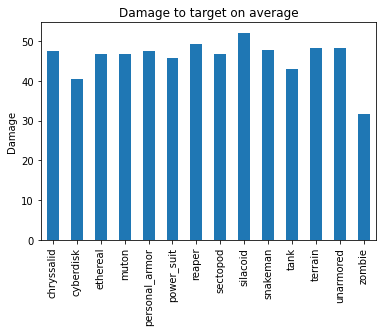

In [3]:
weapon_damages_targets_graph = weapon_damages_targets.groupby(["target"]).mean()
ax = weapon_damages_targets_graph.plot.bar(title="Damage to target on average", legend=False)
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Damage")

### Kinetic Weapons

In [4]:
weapon_damages_targets_kinetic = weapon_damages_targets.loc[ ["pistol", "rifle", "heavy_cannon", "auto_cannon"] ]
weapon_damages_targets_kinetic = weapon_damages_targets_kinetic.swaplevel().unstack()
weapon_damages_targets_kinetic = weapon_damages_targets_kinetic.sort_values(by=["target"])

Text(0, 0.5, 'Damage')

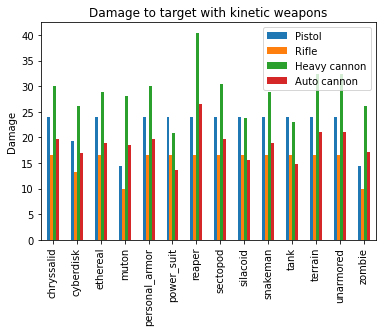

In [5]:
ax = weapon_damages_targets_kinetic.plot.bar(title="Damage to target with kinetic weapons")
ax.legend(["Pistol", "Rifle", "Heavy cannon", "Auto cannon"]);
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Damage")

### Melee

Text(0, 0.5, 'Damage')

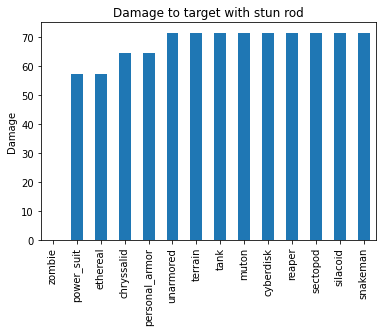

In [6]:
ax = weapon_damages_targets.loc[ "stun_rod" , : ].plot.bar(title="Damage to target with stun rod", legend=False)
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Damage")

### Explosive

Text(0, 0.5, 'Damage')

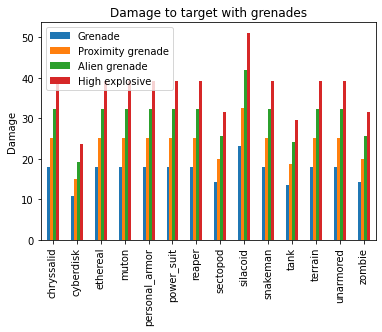

In [7]:
weapon_damages_targets_grenade = weapon_damages_targets.loc[ ["grenade", "proximity_grenade", "alien_grenade", "high_explosive"] ]
weapon_damages_targets_grenade = weapon_damages_targets_grenade.swaplevel().unstack()
weapon_damages_targets_grenade = weapon_damages_targets_grenade.sort_values(by=["target"])
ax = weapon_damages_targets_grenade.plot.bar(title="Damage to target with grenades")
ax.legend(["Grenade", "Proximity grenade", "Alien grenade", "High explosive"]);
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Damage")

Text(0, 0.5, 'Damage')

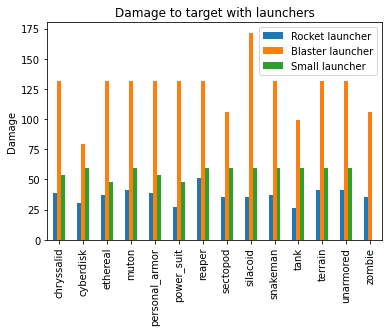

In [8]:
weapon_damages_targets_launcher = weapon_damages_targets.loc[ ["rocket_launcher", "blaster_launcher", "small_launcher"] ]
weapon_damages_targets_launcher = weapon_damages_targets_launcher.swaplevel().unstack()
weapon_damages_targets_launcher = weapon_damages_targets_launcher.sort_values(by=["target"])
ax = weapon_damages_targets_launcher.plot.bar(title="Damage to target with launchers")
ax.legend(["Rocket launcher", "Blaster launcher", "Small launcher"]);
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Damage")

### Laser

Text(0, 0.5, 'Damage')

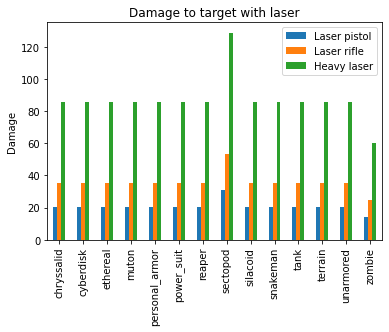

In [9]:
weapon_damages_targets_laser = weapon_damages_targets.loc[ ["laser_pistol", "laser_rifle", "heavy_laser"] ]
weapon_damages_targets_laser = weapon_damages_targets_laser.swaplevel().unstack()
weapon_damages_targets_laser = weapon_damages_targets_laser.sort_values(by=["target"])
ax = weapon_damages_targets_laser.plot.bar(title="Damage to target with laser")
ax.legend(["Laser pistol", "Laser rifle", "Heavy laser"]);
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Damage")

### Plasma

Text(0, 0.5, 'Damage')

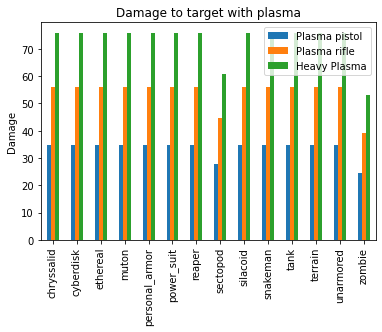

In [10]:
weapon_damages_targets_plasma = weapon_damages_targets.loc[ ["plasma_pistol", "plasma_rifle", "heavy_plasma"] ]
weapon_damages_targets_plasma = weapon_damages_targets_plasma.swaplevel().unstack()
weapon_damages_targets_plasma = weapon_damages_targets_plasma.sort_values(by=["target"])
ax = weapon_damages_targets_plasma.plot.bar(title="Damage to target with plasma")
ax.legend(["Plasma pistol", "Plasma rifle", "Heavy Plasma"]);
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Damage")

### Tank

Text(0, 0.5, 'Damage')

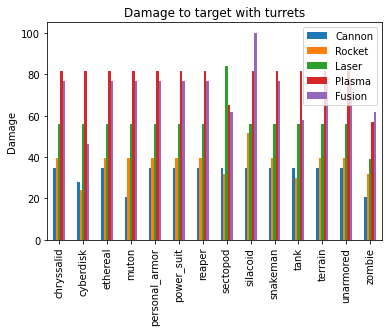

In [11]:
weapon_damages_targets_tank = weapon_damages_targets.loc[ ["cannon_turret", "rocket_turret", "laser_turret", "plasma_turret", "fusion_turret"] ]
weapon_damages_targets_tank = weapon_damages_targets_tank.swaplevel().unstack()
weapon_damages_targets_tank = weapon_damages_targets_tank.sort_values(by=["target"])
ax = weapon_damages_targets_tank.plot.bar(title="Damage to target with turrets")
ax.legend(["Cannon", "Rocket", "Laser", "Plasma", "Fusion"]);
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Damage")

### Target Damage Lists

#### Averages

In [12]:
weapon_damages_average = weapon_damages_targets.groupby(["weapon"]).mean()
weapon_damages_average = weapon_damages_average.sort_values(by=["turn_damage"])

In [13]:
weapon_damages_max = weapon_damages_targets.groupby(["weapon"]).max()
weapon_damages_max = weapon_damages_max.sort_values(by=["turn_damage"])

In [14]:
average_damages_expected = weapon_damages_max.merge(weapon_damages_average, on="weapon")
average_damages_expected = average_damages_expected.rename(columns={"turn_damage_x": "max", "turn_damage_y": "average"})
average_damages_expected = average_damages_expected.sort_values(by=["average"])
average_damages_expected

,max,average
weapon,,
rifle,16.500000,15.321429
grenade,23.237500,16.917411
auto_cannon,26.424933,18.715033
laser_pistol,30.866000,20.871295
pistol,24.024000,22.308000
proximity_grenade,32.532500,23.684375
heavy_cannon,40.425000,28.641250
alien_grenade,41.827500,30.451339
cannon_turret,34.650000,32.175000


Text(0, 0.5, 'Damage')

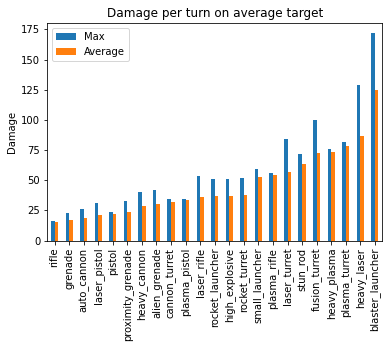

In [15]:
ax = average_damages_expected.plot.bar(title="Damage per turn on average target", legend=False)
ax.legend(["Max", "Average"])
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Damage")

#### Damage Per Time Unit

In [16]:
weapon_damages_per_tu_targets = weapon_data_targets.groupby(["weapon", "target"]).mean()
weapon_damages_per_tu_targets = weapon_damages_per_tu_targets[["target_damage_per_time_unit"]]
weapon_damages_per_tu_targets = weapon_damages_per_tu_targets.rename(columns={"target_damage_per_time_unit": "damage_per_time_unit"})
weapon_damages_per_tu_targets = weapon_damages_per_tu_targets.sort_values(by=["damage_per_time_unit"])

In [17]:
weapon_damages_per_tu_targets_average = weapon_damages_per_tu_targets.groupby(["weapon"]).mean()
weapon_damages_per_tu_targets_average = weapon_damages_per_tu_targets_average.sort_values(by=["damage_per_time_unit"])

In [18]:
weapon_damages_per_tu_targets_max = weapon_damages_per_tu_targets.groupby(["weapon"]).max()
weapon_damages_per_tu_targets_max = weapon_damages_per_tu_targets_max.sort_values(by=["damage_per_time_unit"])

In [19]:
weapon_damages_per_tu_targets_expected = weapon_damages_per_tu_targets_max.merge(weapon_damages_per_tu_targets_average, on="weapon")
weapon_damages_per_tu_targets_expected = weapon_damages_per_tu_targets_expected.rename(columns={"damage_per_time_unit_x": "max", "damage_per_time_unit_y": "average"})
weapon_damages_per_tu_targets_expected = weapon_damages_per_tu_targets_expected.sort_values(by=["average"])
weapon_damages_per_tu_targets_expected

,max,average
weapon,,
grenade,0.866667,0.630952
rifle,0.810714,0.752806
proximity_grenade,1.213333,0.883333
auto_cannon,1.262643,0.894247
heavy_cannon,1.498106,1.061413
pistol,1.155556,1.073016
alien_grenade,1.560000,1.135714
cannon_turret,1.284091,1.192370
high_explosive,1.906667,1.388095


Text(0, 0.5, 'Ratio')

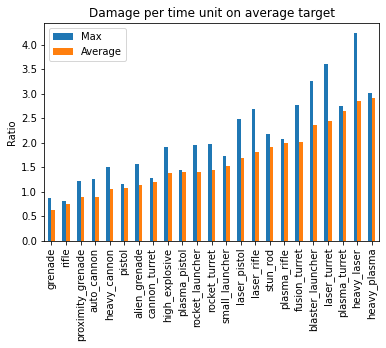

In [20]:
ax = weapon_damages_per_tu_targets_expected.plot.bar(title="Damage per time unit on average target", legend=False)
ax.legend(["Max", "Average"])
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Ratio")

#### Terrain

In [21]:
weapon_damages_terrain = weapon_damages_targets.xs("terrain", level="target")
weapon_damages_terrain = weapon_damages_terrain.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

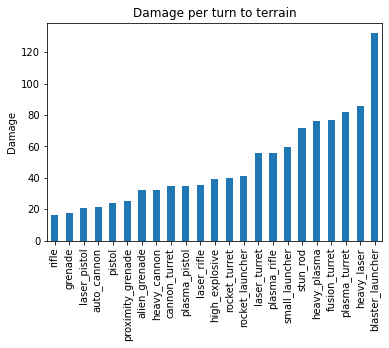

In [22]:
ax = weapon_damages_terrain.plot.bar(title="Damage per turn to terrain", legend=False)
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Damage")

#### Unarmored

In [23]:
weapon_damages_unarmored = weapon_damages_targets.xs("unarmored", level="target")
weapon_damages_unarmored = weapon_damages_unarmored.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

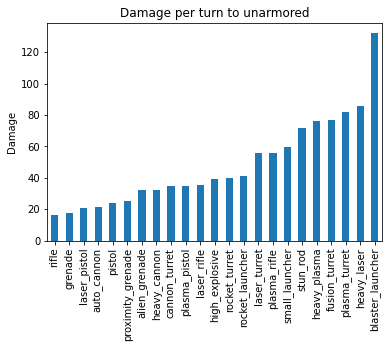

In [24]:
ax = weapon_damages_unarmored.plot.bar(title="Damage per turn to unarmored", legend=False)
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Damage")

#### Personal Armor

In [25]:
weapon_damages_armor = weapon_damages_targets.xs("personal_armor", level="target")
weapon_damages_armor = weapon_damages_armor.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

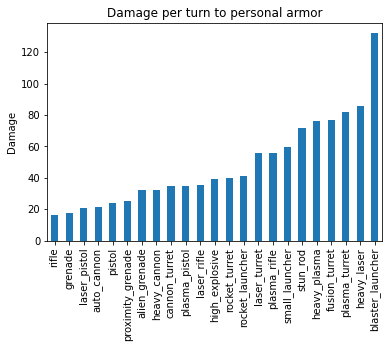

In [26]:
ax = weapon_damages_unarmored.plot.bar(title="Damage per turn to personal armor", legend=False)
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Damage")

#### Power Suit

In [27]:
weapon_damages_power_suit = weapon_damages_targets.xs("power_suit", level="target")
weapon_damages_power_suit = weapon_damages_power_suit.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

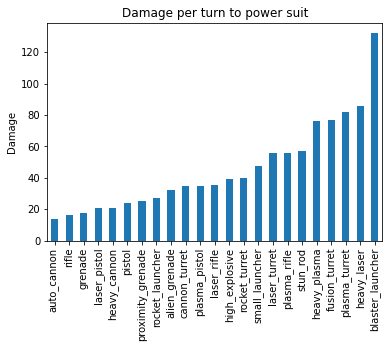

In [28]:
ax = weapon_damages_power_suit.plot.bar(title="Damage per turn to power suit", legend=False)
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Damage")

#### Tank

In [29]:
weapon_damages_tank = weapon_damages_targets.xs("tank", level="target")
weapon_damages_tank = weapon_damages_tank.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

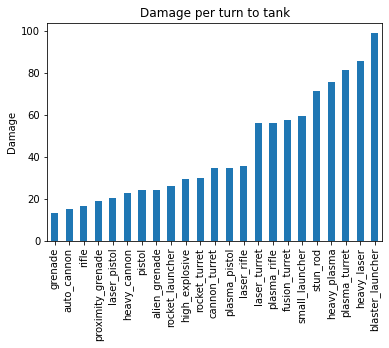

In [30]:
ax = weapon_damages_tank.plot.bar(title="Damage per turn to tank", legend=False)
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Damage")

#### Snakeman

In [31]:
weapon_damages_snakeman = weapon_damages_targets.xs("snakeman", level="target")
weapon_damages_snakeman = weapon_damages_snakeman.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

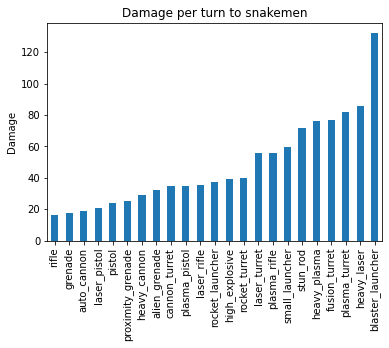

In [32]:
ax = weapon_damages_snakeman.plot.bar(title="Damage per turn to snakemen", legend=False)
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Damage")

#### Ethereal

In [33]:
weapon_damages_ethereal = weapon_damages_targets.xs("ethereal", level="target")
weapon_damages_ethereal = weapon_damages_ethereal.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

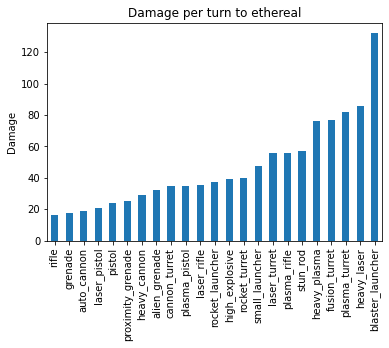

In [34]:
ax = weapon_damages_ethereal.plot.bar(title="Damage per turn to ethereal", legend=False)
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Damage")

#### Muton

In [35]:
weapon_damages_muton = weapon_damages_targets.xs("muton", level="target")
weapon_damages_muton = weapon_damages_muton.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

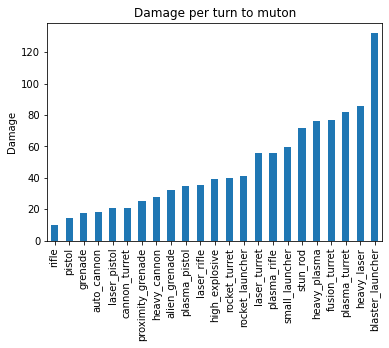

In [36]:
ax = weapon_damages_muton.plot.bar(title="Damage per turn to muton", legend=False)
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Damage")

#### Silacoid

In [37]:
weapon_damages_silacoid = weapon_damages_targets.xs("silacoid", level="target")
weapon_damages_silacoid = weapon_damages_silacoid.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

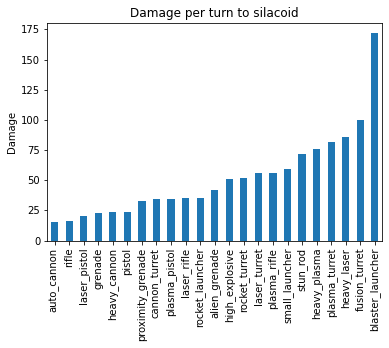

In [38]:
ax = weapon_damages_silacoid.plot.bar(title="Damage per turn to silacoid", legend=False)
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Damage")

#### Chryssalid

In [39]:
weapon_damages_chryssalid = weapon_damages_targets.xs("chryssalid", level="target")
weapon_damages_chryssalid = weapon_damages_chryssalid.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

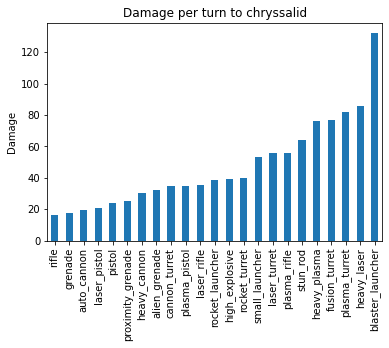

In [40]:
ax = weapon_damages_chryssalid.plot.bar(title="Damage per turn to chryssalid", legend=False)
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Damage")

#### Reaper

In [41]:
weapon_damages_reaper = weapon_damages_targets.xs("reaper", level="target")
weapon_damages_reaper = weapon_damages_reaper.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

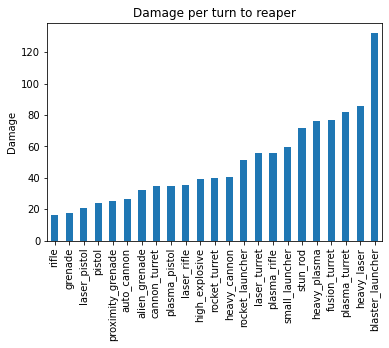

In [42]:
ax = weapon_damages_reaper.plot.bar(title="Damage per turn to reaper", legend=False)
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Damage")

#### Sectopod

In [43]:
weapon_damages_sectopod = weapon_damages_targets.xs("sectopod", level="target")
weapon_damages_sectopod = weapon_damages_sectopod.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

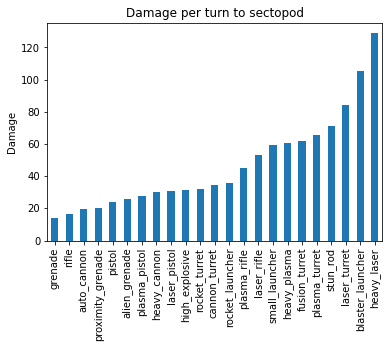

In [44]:
ax = weapon_damages_sectopod.plot.bar(title="Damage per turn to sectopod", legend=False)
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Damage")

#### Cyberdisk

In [45]:
weapon_damages_cyberdisk = weapon_damages_targets.xs("cyberdisk", level="target")
weapon_damages_cyberdisk = weapon_damages_cyberdisk.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

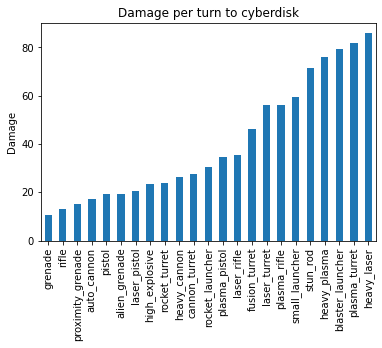

In [46]:
ax = weapon_damages_cyberdisk.plot.bar(title="Damage per turn to cyberdisk", legend=False)
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Damage")

#### Zombie

In [47]:
weapon_damages_zombie = weapon_damages_targets.xs("zombie", level="target")
weapon_damages_zombie = weapon_damages_zombie.sort_values(by=["turn_damage"])

Text(0, 0.5, 'Damage')

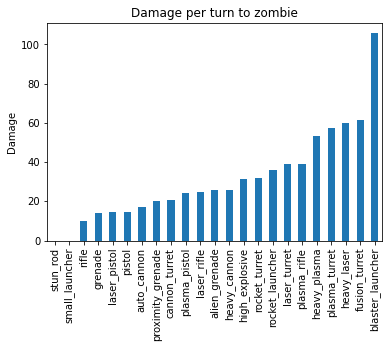

In [48]:
ax = weapon_damages_zombie.plot.bar(title="Damage per turn to zombie", legend=False)
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Damage")